In [2]:
import numpy as np
import pandas as pd
import wandb
import warnings
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, hamming_loss

In [3]:
class LogisticRegression():
    def __init__(self, y_train, learning_rate, threshold, epochs):
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.loss = 0
        self.epochs = epochs
        labels, counts = np.unique(y_train, return_counts=True)
        self.k = counts.shape[0]
        self.labels_dict = {}
        for i in range(len(labels)):
            self.labels_dict[labels[i]] = i
        return
    

    def softmax(self, x):
        exponent = np.dot(x, self.weights) + self.bias
        exponent = np.exp(exponent)
        exponent /= np.sum(exponent, axis=1, keepdims=True)
        return exponent


    def cross_entropy_loss(self, x_train, y_train):
        epsilon = 1e-15
        y_pred = np.clip(self.y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(np.multiply(y_train, np.log(y_pred)))
        return loss
    

    def gradient(self, x_train, y_train):
        weight_gradient = np.dot(x_train.T, (self.y_pred - y_train)) / x_train.shape[0]
        bias_gradient = np.mean(self.y_pred - y_train, axis=0)
        return weight_gradient, bias_gradient
    

    def forward(self, x_train, y_train):
        self.y_pred = self.softmax(x_train)
        loss = self.cross_entropy_loss(x_train, y_train)
        return loss


    def backward(self, x_train, y_train):
        weight_gradient, bias_gradient = self.gradient(x_train, y_train)
        self.weights -= self.learning_rate * weight_gradient
        self.bias -= self.learning_rate * bias_gradient
        return


    def one_hot_encoding(self, Y):
        OneHotEncoding = []
        encoding = []
        
        for i in range(len(Y)):
            encoding = np.zeros(self.k)
            encoding[self.labels_dict[Y[i]]] = 1
            OneHotEncoding.append(encoding)
        return OneHotEncoding


    def predict(self, y_pred):
        return np.argmax(y_pred)
    

    def fit(self, x_train, y_train, x_val, y_val):
        weights = np.zeros((x_train.shape[1], self.k))
        bias = np.zeros(self.k)
        self.weights = weights
        self.bias = bias
        y_one_hot = self.one_hot_encoding(y_train)
        y_one_hot_val = self.one_hot_encoding(y_val)

        
        epoch = 0
        self.y_pred = self.softmax(x_train)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_one_hot)) > 1e-2 and epoch < 4000:
            self.loss = self.forward(x_train, y_one_hot)
            self.backward(x_train, y_one_hot)
            accuracy = self.evaluation(self.y_pred, y_one_hot)
            print("Epoch = ",epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy)
            train_loss = self.loss

            self.loss = self.forward(x_val, y_one_hot_val)
            accuracy = self.evaluation(self.y_pred, y_one_hot_val)
            print("Epoch = ",epoch+1, "Validation Set Loss = ", self.loss, "Accuracy = ", accuracy)
            self.loss = train_loss
            self.y_pred = self.softmax(x_train)
            epoch += 1

        return
    


    def hyperparameter_tune(self, x_val, y_val):                    # Add Code for W&B Logging.
        weights = np.zeros((x_val.shape[1], self.k))
        bias = np.zeros(self.k)
        self.weights = weights
        self.bias = bias
        y_one_hot = self.one_hot_encoding(y_val)

        a = np.array([])
        for epoch in range(self.epochs):
            self.loss = self.forward(x_val, y_one_hot)
            self.backward(x_val, y_one_hot)
            accuracy = self.evaluation(self.y_pred, y_one_hot)
            print("Epoch = ",epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy)
            a = np.append(a, np.array([accuracy]))
        return np.mean(a)
    

    def fit_test(self, x_test, y_test):
        y_one_hot = self.one_hot_encoding(y_test)

        a = np.array([])
        for epoch in range(self.epochs):
            self.loss = self.forward(x_test, y_one_hot)
            self.backward(x_test, y_one_hot)
            accuracy = self.evaluation(self.y_pred, y_one_hot)
            a = np.append(a, np.array([accuracy]))
        return np.mean(a)


    def evaluation(self, predicted, actual):
        score = 0
        for i in range(predicted.shape[0]):
            if (self.predict(actual[i]) == self.predict(predicted[i])):
                score += 1
        return score/predicted.shape[0]

In [10]:
wandb.init(
    project="Assignment 3",
    config={
        "optimizer": "gd",
        "loss": "crossentropy",
        "metric": "accuracy",
        "epoch": 1000
    }
)

# Access the configuration that you have set
config = wandb.config

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [5]:
data = pd.read_csv('./WineQT.csv')
data = data.drop(columns=['Id'])
l = [i for i in data]
data = data.dropna()
data

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1138                 29.0                  40.0  0.99574  3.42       0.75   
1139                 28.0                  38.0  0.99651  3.42       0.82   
1140                 32.0                  44.0  0.99490  3.45       0.58   
1141                 39.0                  51.0  0.99512  3.52       0.76   
1142                 32.0                  44.0  0.99547  3.57       0.71   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1138     11.0        6  
1139      9.5        6  
1140     10.5        5  
1141     11.2        6  
1142     10.2        5  

[1143 rows x 12 columns]

### 1.1 Dataset Analysis and Preprocessing ###

In [6]:
data = np.array([data])
data = data[0]
mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)
minimum = np.min(data, axis = 0)
maximum = np.max(data, axis = 0)
table = PrettyTable(['Attribute', 'Mean', 'Standard Deviation', 'Minimum Value', 'Maximum'])
for i in range(data.shape[1]-1):
    table.add_row([l[i], mean[i], std[i], minimum[i], maximum[i]])
table

+----------------------+---------------------+-----------------------+---------------+---------+
|      Attribute       |         Mean        |   Standard Deviation  | Minimum Value | Maximum |
+----------------------+---------------------+-----------------------+---------------+---------+
|    fixed acidity     |  8.311111111111119  |   1.7468303726275005  |      4.6      |   15.9  |
|   volatile acidity   |  0.531338582677165  |  0.17955459612835611  |      0.12     |   1.58  |
|     citric acid      | 0.26836395450568584 |  0.19659979421574753  |      0.0      |   1.0   |
|    residual sugar    |  2.5321522309711257 |   1.3553241971435854  |      0.9      |   15.5  |
|      chlorides       | 0.08693263342082211 |  0.04724665655215519  |     0.012     |  0.611  |
| free sulfur dioxide  |  15.615485564304462 |   10.246001115067603  |      1.0      |   68.0  |
| total sulfur dioxide |  45.91469816272966  |   32.767786779941396  |      6.0      |  289.0  |
|       density        |  0.9967304111986008 | 0.0019242248343795283 |    0.99007    | 1.00369 |
|          pH          |  3.3110148731408593 |  0.15659551281704343  |      2.74     |   4.01  |
|      sulphates       |  0.6577077865266842 |  0.17032415803626072  |      0.33     |   2.0   |
|       alcohol        |  10.44211140274131  |   1.0817221048833665  |      8.4      |   14.9  |
+----------------------+---------------------+-----------------------+---------------+---------+

[3. 4. 5. 6. 7. 8.]


array([  6,  33, 483, 462, 143,  16])

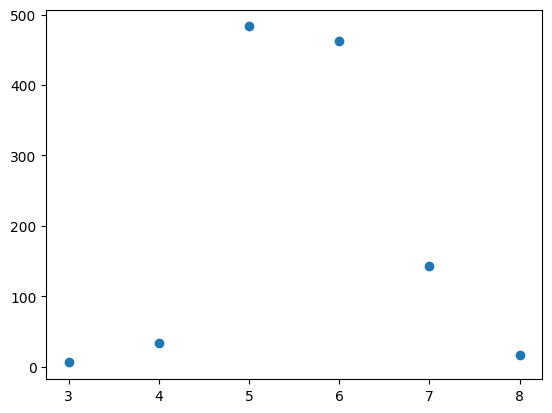

In [7]:
labels, count = np.unique(data[:, 11], return_counts=True)
plt.scatter(labels, count)
# sns.countplot(data[:, 12])
plt.plot()
print(labels)
count

In [8]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

data -= mean
data /= std
# minimum = np.min(data, axis = 0)
# maximum = np.max(data, axis = 0)
# data = (data-minimum)/(maximum-minimum)

X = np.zeros((data.shape[0], data.shape[1]-1))
for i in range(data.shape[1]-1):
    X[:, i] = data[:, i]
y = data[:, data.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.33, random_state=42)

### 1.2 Model Training and Fitting and 1.3 Hyperparameter Tuning ###

In [9]:
import heapq

x = LogisticRegression(y_train, learning_rate=1e-2, threshold=0.5, epochs = 10)
x.fit(x_train, y_train, x_val, y_val)


l = []
heapq.heapify(l)
for learning_rate in range(10):
    for epochs in range(100, 1000, 300):
        x = LogisticRegression(y_val, 0.001+learning_rate*0.01, threshold=0.5, epochs = epochs)
        Accuracy = x.hyperparameter_tune(x_val, y_val)
        heapq.heappush(l, [-Accuracy, 0.001+learning_rate*0.01, epochs])
        wandb.log({"Epochs": epochs, "Accuracy": Accuracy, "Learning Rate": 0.001+learning_rate*0.01})


print("Optimal Value for Epochs = ", l[0][2], "and Learning Rate = ", l[0][1], "Accuracy = ", -l[0][0])


print("\n\n\n\nTraining on Best Set of Hyperparamters")
x = LogisticRegression(y_train, learning_rate=l[0][1], threshold=0.5, epochs=l[0][2])
x.fit(x_train, y_train, x_val, y_val)

print("\n\n\n\nTesting on Best Set of Hyperparamters")
x.fit_test(x_test, y_test)

Epoch =  1 Loss =  1433.407575382444 Accuracy =  0.0075
Epoch =  1 Validation Set Loss =  203.86223586627074 Accuracy =  0.6052631578947368
Epoch =  2 Loss =  1430.5621504541086 Accuracy =  0.58
Epoch =  2 Validation Set Loss =  203.46559658530776 Accuracy =  0.6052631578947368
Epoch =  3 Loss =  1427.7294932479945 Accuracy =  0.58
Epoch =  3 Validation Set Loss =  203.07065893211723 Accuracy =  0.6052631578947368
Epoch =  4 Loss =  1424.90958303569 Accuracy =  0.57875
Epoch =  4 Validation Set Loss =  202.67742014083734 Accuracy =  0.6052631578947368
Epoch =  5 Loss =  1422.1023986943796 Accuracy =  0.57875
Epoch =  5 Validation Set Loss =  202.28587739679583 Accuracy =  0.6052631578947368
Epoch =  6 Loss =  1419.3079187066921 Accuracy =  0.57875
Epoch =  6 Validation Set Loss =  201.89602783658052 Accuracy =  0.6052631578947368
Epoch =  7 Loss =  1416.5261211606628 Accuracy =  0.57875
Epoch =  7 Validation Set Loss =  201.5078685481235 Accuracy =  0.6052631578947368
Epoch =  8 Loss =

0.6680349344978167

We observe using Wandb Logging that number of epochs and learning rate for best performing model are 700 and 0.09 respectively. The test set is evaluated against this model and the corresponding sklearn accuracy is printed on the console.

### 2. Multi-Layer Perceptrons ### 

In [5]:
class MLP():
    # def __init__(self, learning_rate = 0.2, activation_func = 'Sigmoid', optimiser = 'SGD', num_hidden = 1, num_neurons = 10):
    def __init__(self, y_train, learning_rate, activation, optimiser, num_hidden, num_neurons, epochs):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimiser = optimiser
        self.num_hidden = num_hidden
        self.num_neurons = num_neurons
        self.loss = 0
        self.epochs = epochs
        labels, counts = np.unique(y_train, return_counts=True)
        self.k = counts.shape[0]
        self.labels_dict = {}
        for i in range(len(labels)):
            self.labels_dict[labels[i]] = i
        return


    def predict(self, y_pred):
        return np.argmax(y_pred)


    def cross_entropy_loss(self, layer_input, layer_output):
        epsilon = 1e-15
        y_pred = np.clip(self.y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(np.multiply(layer_output, np.log(y_pred))) / layer_input.shape[0]
        return loss


    def activate(self, layer_input):
        if (self.activation == 'Sigmoid'):
            return 1 / (1+np.exp(-layer_input))
        elif (self.activation == 'Tanh'):
            return (1-np.exp(-2*layer_input)) / (1+np.exp(-2*layer_input))
        elif (self.activation == 'ReLU'):
            return np.maximum(0, layer_input)
        return


    def diff_activate(self, input):
        if (self.activation == 'Sigmoid'):
            sig_val = self.activate(input)
            return sig_val * (1-sig_val)
        
        elif (self.activation == 'Tanh'):
            tanh_val = self.activate(input)
            return 1-tanh_val*tanh_val
        
        elif (self.activation == 'ReLU'):
            return np.where(input <= 0, 0, 1)
        return


    def diff_softmax(self, z):
        e_z = np.exp(z)
        softmax = e_z / np.sum(e_z)
        derivative = softmax * (1 - softmax)
        return derivative


    def softmax(self, x):
        exponent = np.exp(x)
        exponent /= np.sum(exponent, axis=0, keepdims=True)
        return exponent

    
    def one_hot_encoding(self, Y):
        OneHotEncoding = np.zeros((Y.shape[0], self.k))
        
        for i in range(len(Y)):
            encoding = np.zeros(self.k)
            encoding[self.labels_dict[Y[i]]] = 1
            OneHotEncoding[i] = encoding
        return OneHotEncoding
    


    def gradient(self, layer_input, layer_output):
        
        
        if (self.optimiser == 'SGD'):
            
            indices = np.arange(layer_input.shape[0])
            np.random.shuffle(indices)
            self.loss = 0

            for j in range(layer_input.shape[0]):
                
                self.loss += self.forward_prop(layer_input[j], layer_output[j])
                delta = -(layer_output[j]-self.y_pred)
                dJdw = np.dot(self.a[len(self.a)-1][:, np.newaxis], np.transpose(delta[:, np.newaxis]))
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))                    
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(layer_input[j][:, np.newaxis], np.transpose(delta[:, np.newaxis]))
                    else:
                        dJdw = np.dot(self.a[len(self.a)-2-i][:, np.newaxis], np.transpose(delta[:, np.newaxis]))
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad

            return



        if (self.optimiser == 'BGD'):

            self.loss = self.forward_prop(layer_input, layer_output)
            delta = -(layer_output - self.y_pred)
            dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta)
            self.weights[len(self.z)-1] -= self.learning_rate*dJdw
            bias_grad = np.mean(delta, axis = 0)
            self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

            for i in range(self.num_hidden):
                delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))
                if (i == self.num_hidden-1):
                    dJdw = np.dot(np.transpose(layer_input), delta)
                else:
                    dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta)
                self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad


        if (self.optimiser == 'Mini-BGD'):

            batch_size = 50
            self.loss = 0

            for j in range(int(layer_input.shape[0]/batch_size)):

                self.loss += self.forward_prop(layer_input[batch_size*j: batch_size*(j+1), ], layer_output[batch_size*j: batch_size*(j+1), ])
                delta = -(layer_output[batch_size*j: batch_size*(j+1), ] - self.y_pred)
                dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta)
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad


                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i]))) 
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(np.transpose(layer_input[batch_size*j: batch_size*(j+1), ]), delta)
                    else:
                        dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta)
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad




    def back_prop(self, layer_input, layer_output):
        self.gradient(layer_input, layer_output)
        return
    

    def forward_prop(self, layer_input, layer_output):
        self.z = []
        self.a = []
        for i in range(self.num_hidden+1):
            z = np.dot(layer_input, self.weights[i])
            if (self.optimiser == 'SGD'):
                z += self.bias[i]
            else:
                for j in range(z.shape[0]):
                    z[j] += self.bias[i]
            
            a = None
            if (i == self.num_hidden):
                a = self.softmax(z)
            else:
                a = self.activate(z)
            
            self.z.append(z)
            if (i != self.num_hidden):
                self.a.append(a)
            layer_input = a

        self.y_pred = layer_input
        loss = self.cross_entropy_loss(layer_output, self.y_pred)
        return abs(loss)


    def initialize_weights_and_biases(self, layer_sizes):
        weights = []
        bias = []
        for i in range(1, len(layer_sizes)):
            input_units = layer_sizes[i - 1]
            output_units = layer_sizes[i]
            weight_matrix = np.random.randn(input_units, output_units) * np.sqrt(2 / input_units)
            bias_vector = np.random.randn(output_units)
            weights.append(weight_matrix)
            bias.append(bias_vector)
        return weights, bias


    def fit(self, x_train, y_train, x_val, y_val):
        y_one_hot = self.one_hot_encoding(y_train)
        y_one_hot_val = self.one_hot_encoding(y_val)

        layer_sizes = [x_train.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(y_one_hot.shape[1])
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        self.y_pred = self.softmax(y_one_hot)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_one_hot)) > 1e-8 and epoch < 4000:
            self.back_prop(x_train, y_one_hot)
            accuracy, precision, recall, f1 = self.evaluation(self.y_pred, y_one_hot)
            print("Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy, "Precision = ", precision, "Recall = ", recall, "F1-Score = ", f1)
            wandb.log({"Training Set Epochs": epoch, "Training Set Loss": self.loss, "Training Set Accuracy": accuracy})
            y_pred = self.y_pred

            self.loss = self.forward_prop(x_val, y_one_hot_val)
            accuracy, precision, recall, f1 = self.evaluation(self.y_pred, y_one_hot_val)
            print("Validation Set Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy, "Precision = ", precision, "Recall = ", recall, "F1-Score = ", f1)
            wandb.log({"Validation Set Epochs": epoch, "Validation Set Loss": self.loss, "Validation Set Accuracy": accuracy})
            
            epoch += 1
            self.y_pred = y_pred
        return
    


    def hyperparameter_tune(self, x_val, y_val):
        y_one_hot = self.one_hot_encoding(y_val)

        layer_sizes = [x_train.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(y_one_hot.shape[1])
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        self.y_pred = self.softmax(y_one_hot)
        accuracy = np.array([])
        precision = np.array([])
        recall = np.array([])
        f1_score = np.array([])
        while abs(self.loss-self.cross_entropy_loss(x_val, y_one_hot)) > 1e-8 and epoch < self.epochs:
            self.back_prop(x_val, y_one_hot)
            a, p, r, f1 = self.evaluation(self.y_pred, y_one_hot)
            accuracy = np.append(accuracy, np.array([a]))
            precision = np.append(precision, np.array([p]))
            recall = np.append(recall, np.array([r]))
            f1_score = np.append(f1_score, np.array([f1]))
            print("Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", a, "Precision = ", p, "Recall = ", r, "F1-Score = ", f1)
            epoch += 1
            self.forward_prop(x_val, y_one_hot)
        return np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1_score)



    def fit_test(self, x_train, y_train, x_test, y_test):
        y_one_hot = self.one_hot_encoding(y_train)
        layer_sizes = [x_train.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(y_one_hot.shape[1])
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        self.y_pred = self.softmax(y_one_hot)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_one_hot)) > 1e-8 and epoch < self.epochs:
            self.back_prop(x_train, y_one_hot)
            accuracy, precision, recall, f1 = self.evaluation(self.y_pred, y_one_hot)
            print("Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy, "Precision = ", precision, "Recall = ", recall, "F1-Score = ", f1)
            y_pred = self.y_pred
            epoch += 1
            self.y_pred = y_pred

        y_one_hot = self.one_hot_encoding(y_test)
        self.forward_prop(x_test, y_test)
        accuracy, precision, recall, f1 = self.evaluation(self.y_pred, y_one_hot)
        print("Accuracy = ", accuracy, "Precision = ", precision, "Recall = ", recall, "F1-score = ", f1)
        return


    def evaluation(self, predicted, actual):
        l1 = np.array([])
        l2 = np.array([])
        for i in range(predicted.shape[0]):
            l1 = np.append(l1, np.array([self.predict(actual[i])]))
            l2 = np.append(l2, np.array([self.predict(predicted[i])]))
        return accuracy_score(l1, l2), precision_score(l1, l2, average = "weighted", zero_division=True), recall_score(l1, l2, average = "weighted", zero_division=True), f1_score(l1, l2, average = "weighted", zero_division=True)

In [7]:
wandb.init(
    project="Q2 Assignment 3",
    config={
        "optimizer": "gd",
        "loss": "crossentropy",
        "metric": "accuracy",
        "epoch": 1000
    }
)

# Access the configuration that you have set
config = wandb.config

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [5]:
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

data = pd.read_csv('./WineQT.csv')
data = data.drop(columns=['Id'])
l = [i for i in data]
data = np.array([data])
data = data[0]

minimum = np.min(data, axis = 0)
maximum = np.max(data, axis = 0)

data = (data-minimum) / (maximum-minimum)
mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)

data -= mean
data /= std

X = np.zeros((data.shape[0], data.shape[1]-1))
for i in range(data.shape[1]-1):
    X[:, i] = data[:, i]
y = data[:, data.shape[1]-1]


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.33)
perceptron = MLP(y_train, learning_rate = 0.0001, activation = 'Sigmoid', optimiser = 'BGD', num_hidden = 5, num_neurons = 10, epochs = 1000)
perceptron.fit(x_train, y_train, x_val, y_val)

Epoch =  1 Loss =  0.05013456762848362 Accuracy =  0.26125 Precision =  0.3949863972437197 Recall =  0.26125 F1-Score =  0.28341368420013197
Validation Set Epoch =  1 Loss =  0.24927346842923911 Accuracy =  0.18421052631578946 Precision =  0.6425292397660819 Recall =  0.18421052631578946 F1-Score =  0.2862649668360755
Epoch =  2 Loss =  0.05013456748904352 Accuracy =  0.26125 Precision =  0.4128628529678659 Recall =  0.26125 F1-Score =  0.28200540186462014
Validation Set Epoch =  2 Loss =  0.24927346749186982 Accuracy =  0.18421052631578946 Precision =  0.6459015940165622 Recall =  0.18421052631578946 F1-Score =  0.2879707540148966
Epoch =  3 Loss =  0.050134567341369535 Accuracy =  0.26 Precision =  0.4123266593820884 Recall =  0.26 F1-Score =  0.28110273807391545
Validation Set Epoch =  3 Loss =  0.2492734665003403 Accuracy =  0.19298245614035087 Precision =  0.6459140896430928 Recall =  0.19298245614035087 F1-Score =  0.3045511368647267
Epoch =  4 Loss =  0.050134567183536906 Accura

By default, average values as weighted values for precision, recall and f1 score are taken.

### 2.2 and 2.3 Model Training and Evaluating Model ###

Epoch =  1 Loss =  0.05013458549383337 Accuracy =  0.19 Precision =  0.3535637108792847 Recall =  0.19 F1-Score =  0.25281098109196215
Epoch =  2 Loss =  0.05013458795750949 Accuracy =  0.42125 Precision =  0.7562015625 Recall =  0.42125 F1-Score =  0.24971196130167106
Epoch =  3 Loss =  0.05013458795750944 Accuracy =  0.00625 Precision =  0.9937890625 Recall =  0.00625 F1-Score =  7.763975155279502e-05
Epoch =  4 Loss =  0.05013458795750973 Accuracy =  0.42125 Precision =  0.7562015625 Recall =  0.42125 F1-Score =  0.24971196130167106
Epoch =  5 Loss =  0.05013458795750927 Accuracy =  0.025 Precision =  0.975625 Recall =  0.025 F1-Score =  0.0012195121951219514
Epoch =  6 Loss =  0.05013458795750972 Accuracy =  0.405 Precision =  0.7590250000000001 Recall =  0.405 F1-Score =  0.23348754448398576
Epoch =  7 Loss =  0.05013458795750967 Accuracy =  0.42125 Precision =  0.7562015625 Recall =  0.42125 F1-Score =  0.24971196130167106
Epoch =  8 Loss =  0.05013458795750943 Accuracy =  0.025 

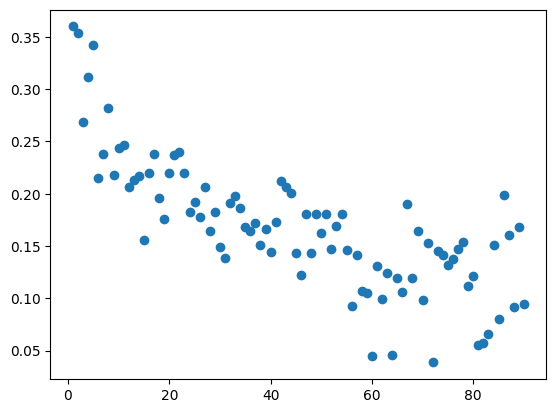

In [6]:
import heapq
from prettytable import PrettyTable

activation_list = ['Sigmoid', 'ReLU', 'Tanh']
optimizers_list = ['BGD', 'Mini-BGD', 'SGD']

l = []
heapq.heapify(l)
for activation in activation_list:
    for optimizer in optimizers_list:
        perceptron = MLP(y_train, learning_rate=0.01, activation=activation, optimiser=optimizer, num_hidden=5, num_neurons=6, epochs=100)
        Accuracy, Precision, Recall, F1 = perceptron.hyperparameter_tune(x_train, y_train)
        heapq.heappush(l, [-Accuracy, activation, optimizer])


print("Optimal Value of 2.2.3 Accuracy = ", Accuracy, "which occurs at activation Function: ", l[0][1], "and Optimiser: ", l[0][2])


l = []
score_l = []
for learning_rate in range(10):
    for epochs in range(100, 1000, 300):
        for num_neurons in (5, 11, 5):
            perceptron = MLP(y_train, learning_rate=0.001+learning_rate*0.01, activation='Sigmoid', optimiser='BGD', num_hidden=5, num_neurons=num_neurons, epochs=1000)
            Accuracy, Precision, Recall, F1 = perceptron.hyperparameter_tune(x_train, y_train)
            heapq.heappush(l, [-Accuracy, learning_rate, epochs, num_neurons])
            score_l.append([learning_rate, epochs, num_neurons, Accuracy, Precision, Recall, F1])

accuracy_l = np.array([])
param_l = []
for i in range(0, len(l)):
    accuracy_l = np.append(accuracy_l, np.array([-l[i][0]]))
    param_l.append([l[i][1], l[i][2], l[i][3]])

index_l = np.arange(len(accuracy_l))+1
plt.scatter(index_l, accuracy_l)
plt.plot()

print("Optimal Value of 2.2.4 Accuracy = ", Accuracy, "which occurs at Learning Rate: ", l[0][1], "Epochs: ", l[0][2], "and Number of Neurons: ", l[0][3])



myTable = PrettyTable(["Learning Rate", "Epochs", "Number of Neurons", "Accuracy", "Precision", "Recall", "F1-Score"])  
for i in range(0, len(score_l)):
    myTable.add_row([score_l[i][0], score_l[i][1], score_l[i][2], score_l[i][3], score_l[i][4], score_l[i][5], score_l[i][6]])
print(myTable)



perceptron = MLP(y_train, learning_rate=0.01, activation='Sigmoid', optimiser='BGD', num_hidden=5, num_neurons=6, epochs=100)
perceptron.fit_test(x_train, y_train, x_test, y_test)

We obtain accuracy of about 0.6 in case of Logistic regression while that of 0.4 in case of MLPs. We can say that Logistic Regression is a special case of MLP with number of hidden layers = 0. Thus, we can say that for multi-class classification for the dataset given, Logistic regression outperforms the performance of MLP Classifier. It can be explained by the growing complexity of Neural Network, as the number of hidden layers increase, the accuracy is decreasing.

### 2.4 Multi-Label Classification ###

In [3]:
wandb.init(
    project="Q2.4 Multi-Label Classification Assignment 3",
    config={
        "optimizer": "gd",
        "loss": "crossentropy",
        "metric": "accuracy",
        "epoch": 1000
    }
)

# Access the configuration that you have set
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: pranav-g (pranavg1). Use `wandb login --relogin` to force relogin


In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

class multilabelMLP(MLP):
    def __init__(self, y_train, learning_rate, activation, optimiser, num_hidden, num_neurons, epochs, threshold):
        super().__init__(y_train, learning_rate, activation, optimiser, num_hidden, num_neurons, epochs)
        self.threshold = threshold
        self.neurons_l = [10, 10, 10]
        return
    

    def compute_loss(self, layer_output):
        epsilon = 1e-15
        layer_pred = np.clip(self.y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(layer_output * np.log(layer_pred) + (1 - layer_output) * np.log(1 - layer_pred))
        return loss / layer_output.shape[0]


    def forward_prop(self, layer_input, layer_output):
        self.z = []
        self.a = []
        for i in range(self.num_hidden+1):
            z = np.dot(layer_input, self.weights[i])
            if (self.optimiser == 'SGD'):
                z += self.bias[i]
            else:
                for j in range(z.shape[0]):
                    z[j] += self.bias[i]
            
            a = self.activate(z)
            self.z.append(z)
            if (i != self.num_hidden):
                self.a.append(a)
            layer_input = a

        self.y_pred = layer_input
        # loss = self.cross_entropy_loss(layer_output, self.y_pred)
        loss = self.compute_loss(layer_output)
        return abs(loss)



    def fit(self, x_train, y_train, x_val, y_val):
        layer_sizes = [x_train.shape[1]]
        for i in range(self.num_hidden):
            layer_sizes.append(self.neurons_l[i])
        layer_sizes.append(y_train.shape[1])
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        self.forward_prop(x_train, y_train)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_train)) > 1e-8 and epoch < self.epochs:
            self.back_prop(x_train, y_train)
            accuracy, precision, recall, f1 = self.evaluation(self.y_pred, y_train)
            print("Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy, "Precision = ", precision, "Recall = ", recall, "F1-Score = ", f1)
            wandb.log({"Multi-Label Classification 2.4 Training Set Epochs": epoch, "Training Set Loss": self.loss, "Training Set Accuracy": accuracy})
            y_pred = self.y_pred
            loss = self.loss

            self.loss = self.forward_prop(x_val, y_val)
            accuracy, precision, recall, f1 = self.evaluation(self.y_pred, y_val)
            print("Validation Set Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy, "Precision = ", precision, "Recall = ", recall, "F1-Score = ", f1)
            wandb.log({"Multi-Label Classification 2.4 Validation Set Epochs": epoch, "Validation Set Loss": self.loss, "Validation Set Accuracy": accuracy})
            
            epoch += 1
            self.y_pred = y_pred
            self.loss = loss
        return
    


    def hyperparameter_tune(self, x_train, y_train):
        layer_sizes = [x_train.shape[1]]
        for i in range(self.num_hidden):
            layer_sizes.append(self.neurons_l[i])
        layer_sizes.append(y_train.shape[1])
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        accuracy = np.array([])
        precision = np.array([])
        recall = np.array([])
        f1_score = np.array([])
        epoch = 0
        self.forward_prop(x_train, y_train)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_train)) > 1e-8 and epoch < self.epochs:
            self.back_prop(x_train, y_train)
            a, p, r, f1 = self.evaluation(self.y_pred, y_train)
            epoch += 1
            accuracy = np.append(accuracy, np.array([a]))
            precision = np.append(precision, np.array([p]))
            recall = np.append(recall, np.array([r]))
            f1_score = np.append(f1_score, np.array([f1]))
            print("Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", a, "Precision = ", p, "Recall = ", r, "F1-Score = ", f1)

        return np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1_score)



    def fit_test(self, x_train, y_train, x_test, y_test):
        layer_sizes = [x_train.shape[1]]
        for i in range(self.num_hidden):
            layer_sizes.append(self.neurons_l[i])
        layer_sizes.append(y_train.shape[1])
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        self.forward_prop(x_train, y_train)
        while abs(self.loss-self.cross_entropy_loss(x_train, y_train)) > 1e-8 and epoch < self.epochs:
            self.back_prop(x_train, y_train)
            accuracy, precision, recall, f1 = self.evaluation(self.y_pred, y_train)
            print("Epoch = ", epoch+1, "Loss = ", self.loss, "Accuracy = ", accuracy, "Precision = ", precision, "Recall = ", recall, "F1-Score = ", f1)
            epoch += 1


        loss = self.forward_prop(x_test, y_test)
        a, p, r, f1 = self.evaluation(self.y_pred, y_test)
        print("Test Set Loss = ", loss, "Accuracy = ", a, "Precision = ", p, "Recall = ", r, "F1-Score = ", f1)
        return
    


    def evaluation(self, predicted, actual):                           # parent class evaluation function over-ridden
        tp = np.sum((actual == 1) & (predicted >= self.threshold), axis = 0)
        tn = np.sum((actual == 0) & (predicted < self.threshold), axis = 0)
        fp = np.sum((actual == 0) & (predicted >= self.threshold), axis = 0)
        fn = np.sum((actual == 1) & (predicted < self.threshold), axis = 0)

        tp_sum = np.sum(tp)
        fn_sum = np.sum(fn)
        fp_sum = np.sum(fp)
        tn_sum = np.sum(tn)
        accuracy = (tp_sum+tn_sum) / (tp_sum+tn_sum+fp_sum+fn_sum)
        precision = tp_sum / (tp_sum+fp_sum)
        recall = tp_sum / (tp_sum+fn_sum)
        f1_score = 2*precision*recall / (precision+recall)
        return accuracy, precision, recall, f1_score


def label_assign(label_set, label_map):
    j = 0
    for i in label_set:
        label_map[i] = j
        j += 1
    return

data = pd.read_csv('advertisement.csv')
data = data.dropna()
data = data.drop(columns='city')

label_map = {}
label_set = set()
for i in data['labels']:
    x = i.split(' ')
    y = []
    for label in x:
        label_set.add(label) 
label_assign(label_set, label_map)



# Perform One-Hot Encoding of all the Categorical Variables
numerical_columns = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

for i in numerical_columns:
    standard = np.array(data[i])
    minimum = np.min(standard, axis=0)
    maximum = np.max(standard, axis=0)
    data[i] = (data[i]-minimum) / (maximum-minimum)

columns_to_exclude = numerical_columns
columns_to_exclude.append('labels')
columns = [col for col in data.columns if col not in columns_to_exclude]
encoder = OneHotEncoder()
enc_data = encoder.fit_transform(data[columns]).toarray()
label_list = data["labels"].str.split().apply(lambda labels: labels if isinstance(labels, list) else [])  # Convert labels to lists

y = np.zeros((label_list.shape[0], len(label_set)))
for i in range(y.shape[0]):
    for label in label_list[i]:
        y[i][label_map[label]] = 1

x_train, x_test, y_train, y_test = train_test_split(enc_data, y, test_size=0.3, random_state=None)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.33, random_state=None)
perceptron = multilabelMLP(y_train, learning_rate=1e-15, activation='ReLU', optimiser='BGD', num_hidden=3, num_neurons=10, epochs=1000, threshold=0.5)
perceptron.fit(x_train, y_train, x_val, y_val)

Epoch =  1 Loss =  84.90057180996935 Accuracy =  0.5551785714285714 Precision =  0.34525837592277114 Recall =  0.31243576567317577 F1-Score =  0.3280280550310224
Validation Set Epoch =  1 Loss =  93.97969979779067 Accuracy =  0.5138888888888888 Precision =  0.3035019455252918 Recall =  0.2746478873239437 F1-Score =  0.2883548983364141
Epoch =  2 Loss =  84.9005718099089 Accuracy =  0.5551785714285714 Precision =  0.34525837592277114 Recall =  0.31243576567317577 F1-Score =  0.3280280550310224
Validation Set Epoch =  2 Loss =  93.97969979771415 Accuracy =  0.5138888888888888 Precision =  0.3035019455252918 Recall =  0.2746478873239437 F1-Score =  0.2883548983364141
Epoch =  3 Loss =  84.9005718098484 Accuracy =  0.5551785714285714 Precision =  0.34525837592277114 Recall =  0.31243576567317577 F1-Score =  0.3280280550310224
Validation Set Epoch =  3 Loss =  93.97969979763762 Accuracy =  0.5138888888888888 Precision =  0.3035019455252918 Recall =  0.2746478873239437 F1-Score =  0.28835489

In [10]:
# observing the parameters we see that accuracy and loss almost remains constant. So, we use arbitrary values.
perceptron = multilabelMLP(y_train, learning_rate=1e-15, activation='ReLU', optimiser='BGD', num_hidden=3, num_neurons=10, epochs=1000, threshold=0.5)
perceptron.fit_test(x_train, y_train, x_test, y_test)

Epoch =  1 Loss =  54.95551351057965 Accuracy =  0.5844642857142858 Precision =  0.33506493506493507 Recall =  0.1988694758478931 F1-Score =  0.24959690422444372
Epoch =  2 Loss =  54.95551351056493 Accuracy =  0.5844642857142858 Precision =  0.33506493506493507 Recall =  0.1988694758478931 F1-Score =  0.24959690422444372
Epoch =  3 Loss =  54.9555135105502 Accuracy =  0.5844642857142858 Precision =  0.33506493506493507 Recall =  0.1988694758478931 F1-Score =  0.24959690422444372
Epoch =  4 Loss =  54.95551351053547 Accuracy =  0.5844642857142858 Precision =  0.33506493506493507 Recall =  0.1988694758478931 F1-Score =  0.24959690422444372
Epoch =  5 Loss =  54.95551351052073 Accuracy =  0.5844642857142858 Precision =  0.33506493506493507 Recall =  0.1988694758478931 F1-Score =  0.24959690422444372
Epoch =  6 Loss =  54.955513510506 Accuracy =  0.5844642857142858 Precision =  0.33506493506493507 Recall =  0.1988694758478931 F1-Score =  0.24959690422444372
Epoch =  7 Loss =  54.955513510

### 3 Multi-Layer Perceptrons for Regression ### 

In [55]:
class MLPRegression():
    def __init__(self, y, learning_rate, activation, optimiser, num_hidden, num_neurons, epochs):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimiser = optimiser
        self.num_hidden = num_hidden
        self.num_neurons = num_neurons
        self.loss = 0
        self.epochs = epochs
        return


    def predict(self, y_pred):
        return np.argmax(y_pred)
    

    def activate(self, layer_input):
        if (self.activation == 'Sigmoid'):
            return 1 / (1+np.exp(-layer_input))
        elif (self.activation == 'Tanh'):
            return (1-np.exp(-2*layer_input)) / (1+np.exp(-2*layer_input))
        elif (self.activation == 'ReLU'):
            return np.maximum(0, layer_input)
        return


    def diff_activate(self, input):
        if (self.activation == 'Sigmoid'):
            sig_val = self.activate(input)
            return sig_val * (1-sig_val)
        elif (self.activation == 'Tanh'):
            tanh_val = self.activate(input)
            return 1-tanh_val*tanh_val
        elif (self.activation == 'ReLU'):
            return np.where(input <= 0, 0, 1)
        return



    def gradient(self, layer_input, layer_output):
        
        
        if (self.optimiser == 'SGD'):

            indices = np.arange(layer_input.shape[0])
            np.random.shuffle(indices)
    

            for j in range(layer_input.shape[0]):
                
                self.loss = self.forward_prop(layer_input[j], layer_output[j])
                y = layer_output[j].reshape(1, 1)
                delta = -(y-self.y_pred)
                dJdw = np.dot(self.a[len(self.a)-1][:, np.newaxis], delta)
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))                    
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(layer_input[j][:, np.newaxis], delta)
                    else:
                        dJdw = np.dot(self.a[len(self.a)-2-i][:, np.newaxis], delta)
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad

            return
        



        if (self.optimiser == 'BGD'):
            
            self.loss = self.forward_prop(layer_input, layer_output)
            y = layer_output.reshape(len(layer_output), 1)
            delta = -(y-self.y_pred)
            dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta) / layer_input.shape[0]
            self.weights[len(self.z)-1] -= self.learning_rate*dJdw
            # bias_grad1 = np.transpose(delta[0])
            # bias_grad = np.asarray(bias_grad1).reshape(-1)
            bias_grad = np.mean(delta, axis = 0)
            self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad

            for i in range(self.num_hidden):
                delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))
                if (i == self.num_hidden-1):
                    dJdw = np.dot(np.transpose(layer_input), delta) / layer_input.shape[0]                 
                else:
                    dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta) / layer_input.shape[0]
                self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad
            return
        



        if (self.optimiser == 'Mini-BGD'):

            batch_size = int(layer_input.shape[0]/6)
            for j in range(int(layer_input.shape[0]/batch_size)):

                self.loss = self.forward_prop(layer_input[batch_size*j: batch_size*(j+1), ], layer_output[batch_size*j: batch_size*(j+1), ])
                y = layer_output.reshape(len(layer_output), 1)
                delta = -(y[batch_size*j: batch_size*(j+1), ]-self.y_pred)
                dJdw = np.dot(np.transpose(self.a[len(self.a)-1]), delta) / batch_size
                self.weights[len(self.z)-1] -= self.learning_rate*dJdw
                bias_grad = np.mean(delta, axis = 0)
                self.bias[len(self.z) - 1] -= self.learning_rate * bias_grad


                for i in range(self.num_hidden):
                    delta = np.multiply(self.diff_activate(self.z[len(self.z)-2-i]), np.dot(delta, np.transpose(self.weights[len(self.z)-1-i])))
                    if (i == self.num_hidden-1):
                        dJdw = np.dot(np.transpose(layer_input[batch_size*j: batch_size*(j+1), ]), delta) / batch_size
                    else:
                        dJdw = np.dot(np.transpose(self.a[len(self.a)-2-i]), delta) / batch_size
                    self.weights[len(self.z)-2-i] -= self.learning_rate*dJdw
                    bias_grad = np.mean(delta, axis = 0)
                    self.bias[len(self.z)-2-i] -= self.learning_rate * bias_grad

            return
        


    def back_prop(self, layer_input, layer_output):
        self.gradient(layer_input, layer_output)
        return
    

    def forward_prop(self, layer_input, layer_output):
        self.z = []
        self.a = []
        for i in range(self.num_hidden+1):
            z = np.dot(layer_input, self.weights[i])

            if (self.optimiser == 'SGD'):
                z += self.bias[i]
            else:
                for j in range(z.shape[0]):
                    z[j] += self.bias[i]
            
            a = self.activate(z)
            self.z.append(z)
            if (i != self.num_hidden):
                self.a.append(a)
            layer_input = a
        self.y_pred = layer_input
        loss = np.mean(np.square(layer_output-self.y_pred))
        return loss


    def loss_compute(self, layer_output):
        y_mean = np.mean(layer_output)
        y_pred = self.y_pred.reshape(layer_output.shape[0])
        numerator = np.sum(np.square(layer_output - y_pred))
        denominator = np.sum(np.square(layer_output - y_mean))
        r_squared = 1 - (numerator / denominator)
        return r_squared



    def initialize_weights_and_biases(self, layer_sizes):
        weights = []
        bias = []
        for i in range(1, len(layer_sizes)):
            input_units = layer_sizes[i - 1]
            output_units = layer_sizes[i]
            weight_matrix = np.random.randn(input_units, output_units) * np.sqrt(2 / input_units)
            bias_vector = np.random.randn(output_units)
            weights.append(weight_matrix)
            bias.append(bias_vector)
        return weights, bias


    def fit(self, x_train, y_train, x_val, y_val):
        layer_sizes = [x_train.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(1)
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        for epoch in range(self.epochs):
            self.back_prop(x_train, y_train)
            r_sq = self.loss_compute(y_train)
            print("Epoch = ", epoch+1, "MSE = ", self.loss, "RMSE = ", np.sqrt(self.loss), "R-Squared Error = ", r_sq)

            self.back_prop(x_val, y_val)
            r_sq = self.loss_compute(y_val)
            print("Validation Set Epoch = ", epoch+1, "MSE = ", self.loss, "RMSE = ", np.sqrt(self.loss), "R-Squared Error = ", r_sq)
            wandb.log({"Validation Set Epochs": epoch, "Validation Set MSE": self.loss, "Validation Set RMSE": np.sqrt(self.loss), "Validation Set R-Squared": r_sq})
        return


    def hyperparameter_tune(self, x_val, y_val):
        layer_sizes = [x_val.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(1)
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        mse = np.array([])
        r_squared = np.array([])

        for epoch in range(self.epochs):
            self.back_prop(x_val, y_val)
            loss = self.loss
            self.forward_prop(x_val, y_val)
            r_sq = self.loss_compute(y_val)
            self.loss = loss
            mse = np.append(mse, np.array([self.loss]))
            r_squared = np.append(r_squared, np.array([r_sq]))
            print("Epoch = ", epoch+1, "MSE = ", self.loss, "RMSE = ", np.sqrt(self.loss), "R-Squared Error = ", r_sq)
        return np.mean(mse), np.sqrt(np.mean(mse)), np.mean(r_sq)
    

    def fit_test(self, x_train, y_train, x_test, y_test):
        layer_sizes = [x_train.shape[1]]
        for _ in range(self.num_hidden):
            layer_sizes.append(self.num_neurons)
        layer_sizes.append(1)
        self.weights, self.bias = self.initialize_weights_and_biases(layer_sizes)
        
        epoch = 0
        for epoch in range(self.epochs):
            self.back_prop(x_train, y_train)
            loss = self.loss
            self.forward_prop(x_train, y_train)
            r_sq = self.loss_compute(y_train)
            self.loss = loss
            print("Epoch = ", epoch+1, "MSE = ", self.loss, "RMSE = ", np.sqrt(self.loss), "R-Squared Error = ", r_sq)

        
        self.forward_prop(x_test, y_test)
        r_sq = self.loss_compute(y_test)
        print("Testing Set, MSE = ", self.loss, "RMSE = ", np.sqrt(self.loss), "R-Squared Error = ", r_sq)
        return

In [49]:
wandb.init(
    project="Q3 Assignment 3",
    config={
        "optimizer": "gd",
        "loss": "crossentropy",
        "metric": "accuracy",
        "epoch": 1000
    }
)

# Access the configuration that you have set
config = wandb.config

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


### 3.1 Data Preprocessing ### 

In [50]:
data = pd.read_csv('./HousingData.csv')
l = [i for i in data]
mean_result = data.mean(skipna=True)
std_result = data.std(skipna=True)

data_types = data.dtypes
for i in range(len(l)):
    if (data_types[i] == 'object' or data_types[i] == 'bool'):
        continue
    data = data.fillna({l[i]: mean_result[l[i]]})
data

CRIM    ZN  INDUS  CHAS    NOX     RM        AGE     DIS  RAD  TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.200000  4.0900    1  296   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.900000  4.9671    2  242   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.100000  4.9671    2  242   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.800000  6.0622    3  222   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.200000  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...        ...     ...  ...  ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.100000  2.4786    1  273   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.700000  2.2875    1  273   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.000000  2.1675    1  273   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.300000  2.3889    1  273   
505  0.04741   0.0  11.93   0.0  0.573  6.030  68.518519  2.5050    1  273   

     PTRATIO       B      LSTAT  MEDV  
0       15.3  396.90   4.980000  24.0  
1       17.8  396.90   9.140000  21.6  
2       17.8  392.83   4.030000  34.7  
3       18.7  394.63   2.940000  33.4  
4       18.7  396.90  12.715432  36.2  
..       ...     ...        ...   ...  
501     21.0  391.99  12.715432  22.4  
502     21.0  396.90   9.080000  20.6  
503     21.0  396.90   5.640000  23.9  
504     21.0  393.45   6.480000  22.0  
505     21.0  396.90   7.880000  11.9  

[506 rows x 14 columns]

In [51]:
data = np.array([data])
data = data[0]
mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)
minimum = np.min(data, axis = 0)
maximum = np.max(data, axis = 0)
table = PrettyTable(['Attribute', 'Mean', 'Standard Deviation', 'Minimum Value', 'Maximum'])
for i in range(data.shape[1]-1):
    table.add_row([l[i], mean[i], std[i], minimum[i], maximum[i]])
table

+-----------+---------------------+---------------------+---------------+---------+
| Attribute |         Mean        |  Standard Deviation | Minimum Value | Maximum |
+-----------+---------------------+---------------------+---------------+---------+
|    CRIM   |  3.611873971193416  |  8.537321779593817  |    0.00632    | 88.9762 |
|     ZN    |  11.211934156378598 |  22.898390901831366 |      0.0      |  100.0  |
|   INDUS   |  11.08399176954735  |  6.6925417540998104 |      0.46     |  27.74  |
|    CHAS   | 0.06995884773662546 | 0.24998576709269318 |      0.0      |   1.0   |
|    NOX    |  0.5546950592885372 | 0.11576311540656153 |     0.385     |  0.871  |
|     RM    |  6.284634387351787  |  0.7019225143345692 |     3.561     |   8.78  |
|    AGE    |  68.51851851851853  |  27.412338662278373 |      2.9      |  100.0  |
|    DIS    |  3.795042687747034  |  2.103628356344459  |     1.1296    | 12.1265 |
|    RAD    |  9.549407114624506  |  8.698651117790645  |      1.0      |   24.0  |
|    TAX    |  408.2371541501976  |  168.3704950393814  |     187.0     |  711.0  |
|  PTRATIO  |  18.455533596837967 |  2.162805191482142  |      12.6     |   22.0  |
|     B     |  356.67403162055257 |  91.20460745217272  |      0.32     |  396.9  |
|   LSTAT   |  12.71543209876544  |  7.0058059292206805 |      1.73     |  37.97  |
+-----------+---------------------+---------------------+---------------+---------+

[]

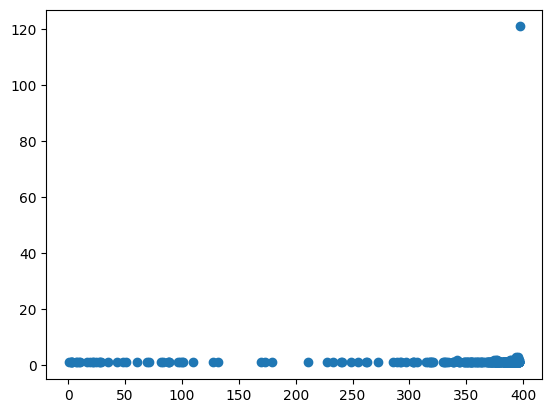

In [52]:
labels, count = np.unique(data[:, 11], return_counts=True)
plt.scatter(labels, count)
plt.plot()

In [56]:
data = np.array([data])
data = data[0]

mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)
data -= mean
data /= std

X = np.zeros((data.shape[0], data.shape[1]-1))
for i in range(data.shape[1]-1):
    X[:, i] = data[:, i]
y = data[:, data.shape[1]-1]


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.33)
perceptron = MLPRegression(y, learning_rate = 0.1, activation = 'Sigmoid', optimiser = 'BGD', num_hidden = 6, num_neurons = 4, epochs = 1000)
perceptron.fit(x_train, y_train, x_val, y_val)

Epoch =  1 MSE =  1.418002267301018 RMSE =  1.1907990037369942 R-Squared Error =  -0.3287521595680516
Validation Set Epoch =  1 MSE =  1.4462777735661962 RMSE =  1.2026128943122953 R-Squared Error =  -0.3552868093492054
Epoch =  2 MSE =  1.329980710746761 RMSE =  1.153247896484863 R-Squared Error =  -0.246274435652039
Validation Set Epoch =  2 MSE =  1.3579328046525718 RMSE =  1.1653037392253454 R-Squared Error =  -0.27250278463068156
Epoch =  3 MSE =  1.2608657021352878 RMSE =  1.1228827641990449 R-Squared Error =  -0.18151347096261583
Validation Set Epoch =  3 MSE =  1.2893272289287592 RMSE =  1.1354854595849122 R-Squared Error =  -0.2082161642370226
Epoch =  4 MSE =  1.2094258794352006 RMSE =  1.099739005144039 R-Squared Error =  -0.13331475969537698
Validation Set Epoch =  4 MSE =  1.2380008353666452 RMSE =  1.112654859049582 R-Squared Error =  -0.16012119407422154
Epoch =  5 MSE =  1.1721926788114925 RMSE =  1.0826784743456814 R-Squared Error =  -0.09842779654014899
Validation Set

### 3.3 and 3.4 Model Training and Building ###

In [57]:
from prettytable import PrettyTable

activation_list = ['Sigmoid', 'ReLU', 'Tanh']
optimizers_list = ['BGD', 'Mini-BGD', 'SGD']

for activation in activation_list:
    for optimizer in optimizers_list:
        perceptron = MLPRegression(y_train, learning_rate=0.01, activation=activation, optimiser=optimizer, num_hidden=5, num_neurons=6, epochs=100)
        mse, rmse, r_sq = perceptron.hyperparameter_tune(x_train, y_train)
        print("Activation Function: ", activation, "Optimizer: ", optimizer, "MSE = ", mse, "RMSE = ", rmse, "R-Squared = ", r_sq)



score_l = []
for learning_rate in range(10):
    for epochs in range(100, 1000, 300):
        for num_neurons in (5, 11, 5):
            perceptron = MLPRegression(y_train, learning_rate=0.001+learning_rate*0.01, activation='Sigmoid', optimiser='BGD', num_hidden=5, num_neurons=num_neurons, epochs=epochs)
            mse, rmse, r_sq = perceptron.hyperparameter_tune(x_train, y_train)
            score_l.append([learning_rate, epochs, num_neurons, mse, rmse, r_sq])


myTable = PrettyTable(["Learning Rate", "Epochs", "Number of Neurons", "MSE", "RMSE", "R-Squared Error"])  
for i in range(0, len(score_l)):
    myTable.add_row([score_l[i][0], score_l[i][1], score_l[i][2], score_l[i][3], score_l[i][4], score_l[i][5]])
print(myTable)

Epoch =  1 MSE =  1.22640715798469 RMSE =  1.1074326877895062 R-Squared Error =  -0.14759494292149844
Epoch =  2 MSE =  1.2242102715266658 RMSE =  1.1064403605828312 R-Squared Error =  -0.14556693929579767
Epoch =  3 MSE =  1.2220449166354836 RMSE =  1.1054614044078988 R-Squared Error =  -0.14356811337577646
Epoch =  4 MSE =  1.2199107355946317 RMSE =  1.1044956928818834 R-Squared Error =  -0.1415981290198316
Epoch =  5 MSE =  1.2178073692684366 RMSE =  1.1035430980566352 R-Squared Error =  -0.1396566490425295
Epoch =  6 MSE =  1.2157344574021125 RMSE =  1.1026034905631819 R-Squared Error =  -0.13774333548384954
Epoch =  7 MSE =  1.2136916389095798 RMSE =  1.1016767397515388 R-Squared Error =  -0.1358578498671692
Epoch =  8 MSE =  1.2116785521492608 RMSE =  1.1007627138258549 R-Squared Error =  -0.13399985344620546
Epoch =  9 MSE =  1.209694835188074 RMSE =  1.0998612799749221 R-Squared Error =  -0.1321690074411268
Epoch =  10 MSE =  1.2077401260538496 RMSE =  1.0989723044980932 R-Squa

In [58]:
# After observing the values, we are running the model on test set having the values of hyperparameters as follows:
perceptron = MLPRegression(y_train, learning_rate=0.091, activation='Sigmoid', optimiser='BGD', num_hidden=5, num_neurons=11, epochs=700)
perceptron.fit_test(x_train, y_train, x_test, y_test)

Epoch =  1 MSE =  1.116518138616462 RMSE =  1.0566542190406765 R-Squared Error =  -0.03995455851934593
Epoch =  2 MSE =  1.1098225951493028 RMSE =  1.0534811793047385 R-Squared Error =  -0.034701930382639024
Epoch =  3 MSE =  1.1042225889814348 RMSE =  1.0508199603078705 R-Squared Error =  -0.030284806392230967
Epoch =  4 MSE =  1.0995134055548417 RMSE =  1.048576847710668 R-Squared Error =  -0.026550328472230822
Epoch =  5 MSE =  1.0955320380805293 RMSE =  1.0466766635788387 R-Squared Error =  -0.023376426976982057
Epoch =  6 MSE =  1.0921483194381774 RMSE =  1.0450590028501632 R-Squared Error =  -0.02066525356995741
Epoch =  7 MSE =  1.0892579157030493 RMSE =  1.0436751964586728 R-Squared Error =  -0.01833803493059416
Epoch =  8 MSE =  1.0867768360825527 RMSE =  1.042485892510087 R-Squared Error =  -0.016331056168158442
Epoch =  9 MSE =  1.084637148380091 RMSE =  1.0414591438842384 R-Squared Error =  -0.01459252970962499
Epoch =  10 MSE =  1.0827836392491672 RMSE =  1.040568901730763